<h1> IMPORTACIONES </h1>

In [14]:
import numpy as np
import pandas as pd
import os

In [15]:
from google.analytics.data import BetaAnalyticsDataClient
from google.analytics.data import DateRange
from google.analytics.data import Dimension
from google.analytics.data import Metric
from google.analytics.data import RunReportRequest
from google.analytics.data import OrderBy


<h1>CONEXION A NUESTRA PROPIEDAD DE ANALYTICS</h1>

In [4]:
## Set up global variables

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'RUTA_ARCHIVO_JSON_CREDENCIALES'
property_id = 'ID_PROPIEDAD_ANALYTICS'

client = BetaAnalyticsDataClient()

<h1> CREAR REQUEST </h1>

In [17]:
## Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    
    # Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])

    row_index_named = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])

    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')), 
                          index = row_index_named, columns = metric_names)
    return output

In [18]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2022-06-01", end_date="today")],
    )

request

property: "properties/363959708"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2022-06-01"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [19]:
format_report(request)

averageSessionDuration  activeUsers
month sessionMedium                                     
07    (none)                     276.379730         37.0
      cpc                         64.870239        234.0
      organic                    181.239365        192.0
      referral                   405.805145          8.0
08    (none)                     191.845871        681.0
      (not set)                  379.292725         18.0
      Social                     495.542542          5.0
      cpc                        148.687683        910.0
      organic                    165.327454       1145.0
      referral                   288.973480       1380.0
09    (none)                     267.544342         71.0
      (not set)                  155.889526          6.0
      cpc                        102.338585        585.0
      organic                    187.952820        464.0
      referral                   456.365875         38.0

<h1>Exportar a excel y csv para poder manipular los datos</h1>

In [20]:
output_df = format_report(request)

## Export to Excel
output_df.reset_index().to_excel('GA4_python_output.xlsx', sheet_name = 'GA4_report', engine = 'xlsxwriter')

In [21]:
## Export to CSV
output_df.to_csv('GA4_python_output.csv')

In [22]:
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
monhtly_users_pivot = pd.pivot_table(output_df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)

In [15]:
monhtly_users_pivot

sessionMedium,(none),(not set),Social,cpc,organic,referral
month,,,,,,
07,37,0,0,234,192,8
08,681,18,5,910,1145,1380
09,71,6,0,585,464,38


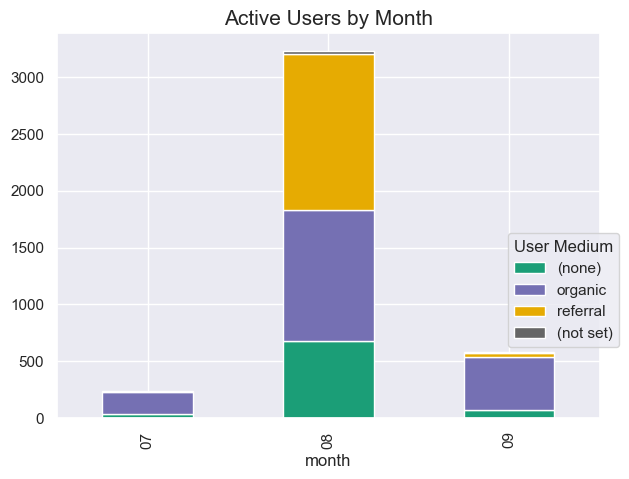

In [16]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)', 'organic', 'referral', '(not set)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

GA4 Traffic Report

In [16]:
## Global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'RUTA_ARCHIVO_JSON_CREDENCIALES'
property_id = 'ID_PROPIEDAD_ANALYTICS'
client = BetaAnalyticsDataClient()

## Report dates
end_date = 'today' ## ("today" or "yyyy-mm-dd")
no_days = 90

In [27]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

def produce_report (end_date, no_days, property_id = property_id, client = client):
    daily_traffic_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="date"), 
                        Dimension(name="sessionMedium")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                        OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="pagePath")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )
    
    
    landing_page_users_request = RunReportRequest(
            property='properties/'+property_id,
            dimensions=[Dimension(name="landingPage")],
            metrics=[Metric(name="activeUsers")],
            order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
            date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
        )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    active_users_pivot.columns = active_users_pivot.columns.map(str)
    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)
    pie_data.plot.pie(ax=axs1,
                  y='activeUsers',  # Nombre de la columna que contiene los datos
                  colormap='Dark2',
                  title='Active Users by Medium',
                  legend=False,
                  label=False,
                  startangle=0,
                  autopct=lambda p: f'{p:.0f}%').set_ylabel('')
    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pgaes output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

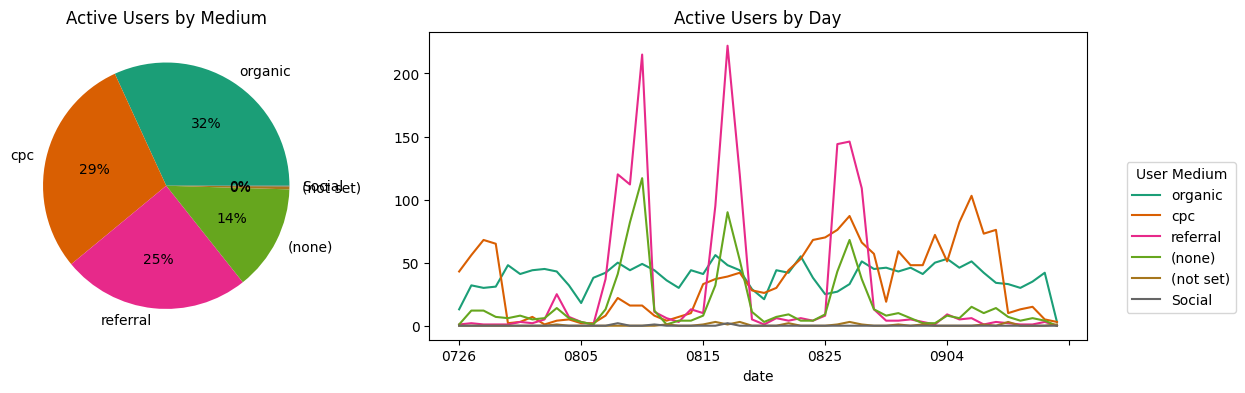


Top 10 Landing Pages


,activeUsers
landingPage,
/,3842
(not set),109
/brand/doite,103
/brand/trezeta,101
/brand/hering,92
/brand/kayland,69
/brand/kannu,65
/brand/dokha,51
/brand/maui-and-sons,49



Top 10 Visited Pages


,activeUsers
pagePath,
/,3896
/collection/calzado-general-hombre,397
/collection/parka-general-hombre,365
/search,328
/collection/sale,287
/collection/parka-general-mujer,280
/collection/polerones-y-polar-general-hombre,264
/collection/calzado-general-mujer,232
/collection/polerones-y-polar-general-mujer,179


In [28]:
produce_report(end_date, no_days)